In [49]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib import cm
from pricer.pde_solver import ADICallPDE, PDESolverConfig

colors = [x["color"] for x in list(plt.rcParams['axes.prop_cycle'])]

In [50]:
from neural_network.torch_model import PricerNetTorch
from neural_network.config import pipeline_configs

In [74]:
import math
from scipy.stats import norm
from scipy.optimize import brentq

def black_scholes_call_price(S, K, T, r, sigma):
    """Price of a European call option using Black-Scholes formula."""
    if T <= 0 or sigma <= 0:
        return max(S - K, 0)
    
    d1 = (math.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    
    call_price = S * norm.cdf(d1) - K * math.exp(-r * T) * norm.cdf(d2)
    return call_price

def implied_volatility(price, underlier_price, strike, expiry, interest_rate, tol=1e-6, max_iter=1000):
    """Compute implied volatility for a European call option using Brent's method."""
    
    def objective(sigma):
        return black_scholes_call_price(underlier_price, strike, expiry, interest_rate, sigma) - price
    
    try:
        # Use Brent's method to solve for the root
        implied_vol = brentq(objective, 0.01, 1.0, xtol=tol, maxiter=max_iter)
        return implied_vol
    except ValueError:
        return float('nan')

In [97]:
seed = 20250420
model_config = pipeline_configs["heston_call"].model

# df = pd.read_csv(r"D:\MSc_Szakdolgozat\codebase\src\hyperparam_optim\20250418\heston_call_third_round.csv")

model_config.layer_number = 8 # df.iloc[0]["layer_number"]
model_config.neuron_per_layer = 48 # df.iloc[0]["neuron_per_layer"]
model_config.hidden_layer_activation = "tanh" # df.iloc[0]["hidden_layer_activation"]
model_config.learning_rate = 0.001 # df.iloc[0]["learning_rate"]
model_config.lambda_param = 0.01 # df.iloc[0]["lambda_param"]

model = PricerNetTorch(
    config={
            "input_variables": model_config.input_variables,
            "target_variables": model_config.target_variables,
            "layer_number": model_config.layer_number,
            "neuron_per_layer": model_config.neuron_per_layer,
            "activation_function": model_config.hidden_layer_activation,
            "learning_rate": model_config.learning_rate,
            "lambda_param": model_config.lambda_param,
            "calc_greek_regularization": True,
            "greek_weighting": False,
        }
)
model_path = os.path.join(r"D:\MSc_Szakdolgozat\codebase\src", "saved_models", f"{seed}", f"ADICallPDE_{model_config.neuron_per_layer}_{model_config.layer_number}_{model_config.hidden_layer_activation}{'_greek_reg' if model_config.calc_greek_regularization else ''}{'_weighted' if model_config.greek_weighting and False else ''}{'_lambda_' + str(model_config.lambda_param) if model_config.lambda_param else ''}.model")

model.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device("cpu")))
model

PricerNetTorch(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=48, bias=True)
    (1): Tanh()
    (2): Linear(in_features=48, out_features=48, bias=True)
    (3): Tanh()
    (4): Linear(in_features=48, out_features=48, bias=True)
    (5): Tanh()
    (6): Linear(in_features=48, out_features=48, bias=True)
    (7): Tanh()
    (8): Linear(in_features=48, out_features=48, bias=True)
    (9): Tanh()
    (10): Linear(in_features=48, out_features=48, bias=True)
    (11): Tanh()
    (12): Linear(in_features=48, out_features=48, bias=True)
    (13): Tanh()
    (14): Linear(in_features=48, out_features=48, bias=True)
    (15): Tanh()
    (16): Linear(in_features=48, out_features=1, bias=True)
    (17): Softplus(beta=1.0, threshold=20.0)
  )
  (loss_fn): MSELoss()
)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 85.19it/s]


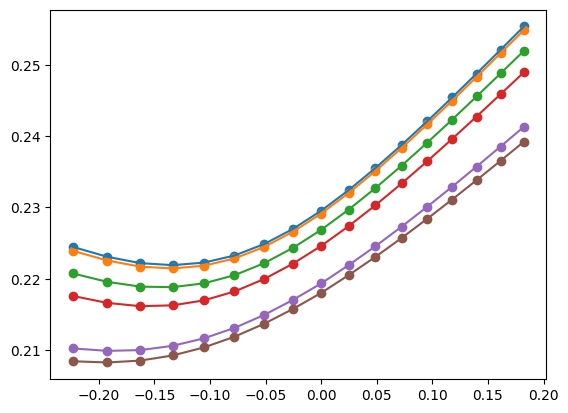

,initial_variance,interest_rate,corr,kappa,variance_theta,sigma,underlier_price,expiry,price,implied_vol
0,0.06,0.06,-0.25,1.75,0.04,0.4,0.800,0.343396,0.003075,0.223912
1,0.06,0.06,-0.25,1.75,0.04,0.4,0.825,0.343396,0.005140,0.222559
2,0.06,0.06,-0.25,1.75,0.04,0.4,0.850,0.343396,0.008247,0.221697
3,0.06,0.06,-0.25,1.75,0.04,0.4,0.875,0.343396,0.012722,0.221445
4,0.06,0.06,-0.25,1.75,0.04,0.4,0.900,0.343396,0.018879,0.221828
...,...,...,...,...,...,...,...,...,...,...
97,0.06,0.06,-0.25,1.75,0.04,0.4,1.100,0.830137,0.179051,0.228405
98,0.06,0.06,-0.25,1.75,0.04,0.4,1.125,0.830137,0.199880,0.231116
99,0.06,0.06,-0.25,1.75,0.04,0.4,1.150,0.830137,0.221313,0.233837
100,0.06,0.06,-0.25,1.75,0.04,0.4,1.175,0.830137,0.243259,0.236547


In [114]:
initial_state = {
    "initial_variance": 0.06,
    "interest_rate": 0.06,
    "corr": -0.25,
    "kappa": 1.75,
    "variance_theta": 0.04,
    "sigma": 0.4,
}

market_data = []
for expiry in [
    # 30/365, 61/365,
    91/265,121/365, 152/365, 182/365,
    273/365, 303 / 365
]:
    pricer = ADICallPDE(
            PDESolverConfig(
                underlier_price_grid=np.array([]),
                time_grid=np.linspace(0, expiry, 101),
                strike=1.0,
                interest_rate=initial_state["interest_rate"],
                corr=initial_state["corr"],
                kappa=initial_state["kappa"],
                variance_theta=initial_state["variance_theta"],
                sigma=initial_state["sigma"],
                n=26,
                m=301,
            )
        )
    for underlier_price in np.arange(0.80, 1.21, 0.025):
        instrument = initial_state.copy()
        instrument.update(
            {
                "underlier_price": underlier_price,
                "expiry": expiry
            }
        )
        price = pricer.price([
            [instrument["initial_variance"], expiry, underlier_price]
        ])[0]
        
        implied_vol = implied_volatility(price, underlier_price, 1.0, expiry, initial_state["interest_rate"])
        
        instrument.update({"price": price, "implied_vol": implied_vol})

        market_data.append(instrument)
market = pd.DataFrame(market_data)

for exp, exp_df in market.groupby("expiry"):
    plt.plot(np.log(exp_df["underlier_price"]), exp_df["implied_vol"])
    plt.scatter(np.log(exp_df["underlier_price"]), exp_df["implied_vol"])

plt.show()
market

In [115]:
def calib_step(calib_params, calib_column_map, market):
    for col_name, i in calib_column_map.items():
        market.loc[:, "model_" + col_name] = calib_params[i]

    pricing_cols = []
    for c in model_config.input_variables:
        if c not in calib_column_map:
            pricing_cols.append(c)
        else:
            pricing_cols.append("model_" + c)
    
    model_price = model(torch.tensor(market[pricing_cols].values, dtype=torch.float32))
    market["model_price"] = model_price.detach().numpy().flatten()

    loss = torch.nn.MSELoss()(
        torch.tensor(market[["price"]].values, dtype=torch.float32),
        model_price
    ).item()
    return loss

calib_step(
    np.array([0.04, -0.5, 1.5, 0.04, 0.1]),
    calib_column_map = {
        "initial_variance": 0,
        "corr": 1,
        "kappa": 2,
        "variance_theta": 3,
        "sigma": 4,
    },
    market=market
)

7.641432603122666e-06

In [116]:
f = lambda x: calib_step(
    x,
    calib_column_map = {
        "initial_variance": 0,
        "corr": 1,
        "kappa": 2,
        "variance_theta": 3,
        "sigma": 4,
    },
    market=market
)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 299
         Function evaluations: 506
initial_variance: 0.0626, true param value: 0.06
corr: -0.5362, true param value: -0.25
kappa: 3.9511, true param value: 1.75
variance_theta: 0.0392, true param value: 0.04
sigma: 0.2723, true param value: 0.4


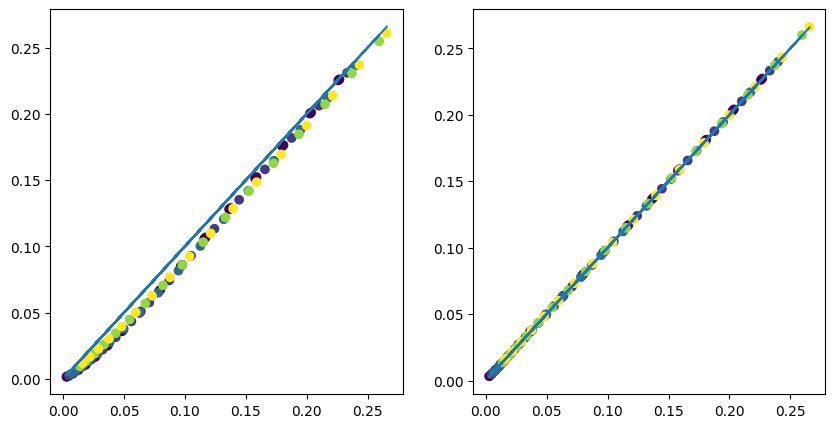

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 89.15it/s]


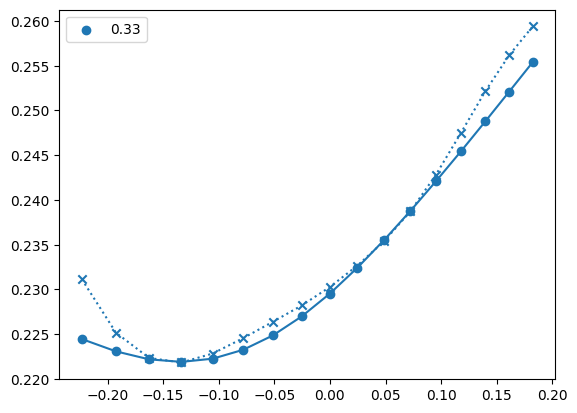

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 87.78it/s]


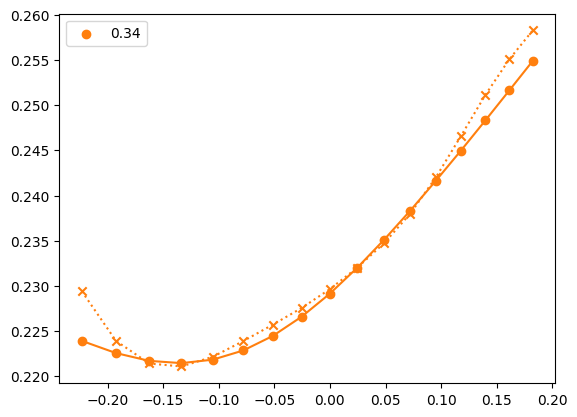

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 91.09it/s]


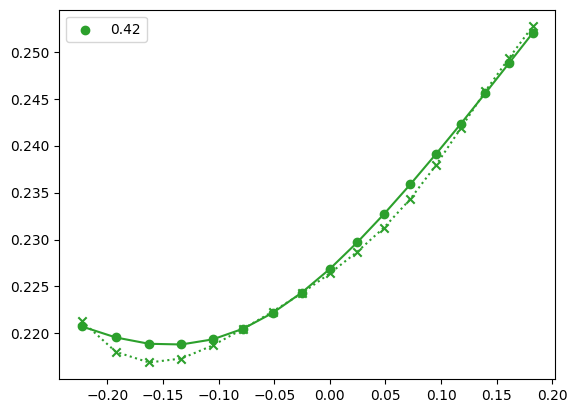

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.48it/s]


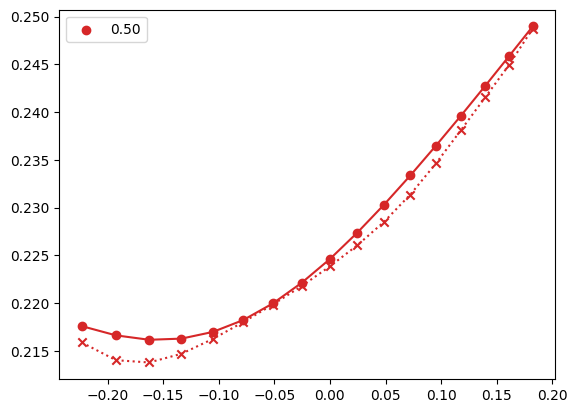

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.71it/s]


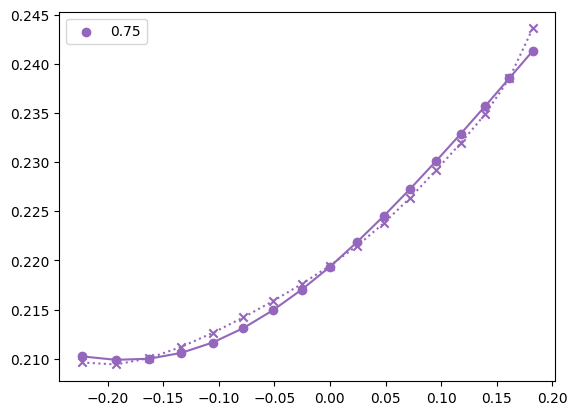

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 90.96it/s]


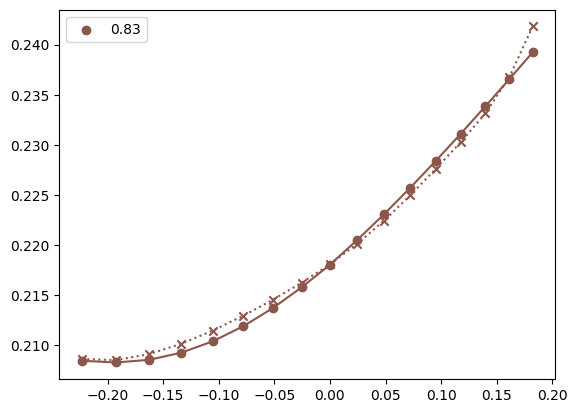

In [117]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

init_guess = np.array([
    (np.random.uniform(0.1, 0.25, 1) ** 2)[0],
    np.random.uniform(-0.5, 0.3, 1)[0],
    np.random.uniform(1.0, 4.0, 1)[0],
    (np.random.uniform(0.1, 0.25, 1) ** 2)[0],
    np.random.uniform(0.1, 0.6, 1)[0],
    # 0.04, -0.6, 2.25, 0.04, 0.2
])

calib_step(
    init_guess,
    calib_column_map = {
        "initial_variance": 0,
        "corr": 1,
        "kappa": 2,
        "variance_theta": 3,
        "sigma": 4,
    },
    market=market
)

ax[0].scatter(market["price"], market["model_price"], c=market["expiry"])
ax[0].plot(market["price"], market["price"])

bounds = [(0.005, 0.1), (-1.0, 1.0), (1.0, None), (0.001, 0.1), (0.1, None)]
calib_params = minimize(f, init_guess, method="Nelder-Mead",
         bounds=bounds,
         options={'disp': True}
).x

for param_name, i in {
        "initial_variance": 0,
        "corr": 1,
        "kappa": 2,
        "variance_theta": 3,
        "sigma": 4,
    }.items():
    print(f"{param_name}: {calib_params[i]:.4f}, true param value: {market.iloc[0][param_name]}")


ax[1].scatter(market["price"], market["model_price"], c=market["expiry"])
ax[1].plot(market["price"], market["price"])

plt.show()

for _, row in market.iterrows():
    implied_vol = implied_volatility(row["model_price"], row["underlier_price"], 1.0, row["expiry"], initial_state["interest_rate"])
    market.loc[_, "model_implied_vol"] = implied_vol

for i, (exp, exp_df) in enumerate(market.groupby("expiry")):
    pricer = ADICallPDE(
        PDESolverConfig(
            underlier_price_grid=np.array([]),
            time_grid=np.linspace(0, exp, 101),
            strike=1.0,
            interest_rate=exp_df.iloc[0]["interest_rate"],
            corr=exp_df.iloc[0]["model_corr"],
            kappa=exp_df.iloc[0]["model_kappa"],
            variance_theta=exp_df.iloc[0]["model_variance_theta"],
            sigma=exp_df.iloc[0]["model_sigma"],
            n=26,
            m=301,
        )
    )
    price = pricer.price(exp_df[["model_initial_variance", "expiry", "underlier_price"]].values)
    exp_df["model_param_price"] = price

    for _, row in exp_df.iterrows():
        implied_vol = implied_volatility(row["model_param_price"], row["underlier_price"], 1.0, row["expiry"], initial_state["interest_rate"])
        exp_df.loc[_, "model_param_implied_vol"] = implied_vol
    
    plt.plot(np.log(exp_df["underlier_price"]), exp_df["implied_vol"], c=colors[i])
    plt.scatter(np.log(exp_df["underlier_price"]), exp_df["implied_vol"], c=colors[i], label=f"{exp:.2f}")

    plt.plot(np.log(exp_df["underlier_price"]), exp_df["model_implied_vol"], linestyle=":", c=colors[i])
    plt.scatter(np.log(exp_df["underlier_price"]), exp_df["model_implied_vol"], marker="x", c=colors[i])
    
    # plt.plot(np.log(exp_df["underlier_price"]), exp_df["model_param_implied_vol"], linestyle="-.", c=colors[i])
    # plt.scatter(np.log(exp_df["underlier_price"]), exp_df["model_param_implied_vol"], marker="v", c=colors[i])

    plt.legend()
    plt.show()

# plt.legend()
# plt.show()

In [44]:
market

,initial_variance,interest_rate,corr,kappa,variance_theta,sigma,underlier_price,expiry,price,implied_vol,model_initial_variance,model_corr,model_kappa,model_variance_theta,model_sigma,model_price,model_implied_vol
0,0.05,0.05,-0.1,2.0,0.05,0.2,0.800,0.082192,0.000006,0.227010,0.04041,-0.230777,3.021849,0.050241,0.100003,0.000752,NaN
1,0.05,0.05,-0.1,2.0,0.05,0.2,0.825,0.082192,0.000031,0.225754,0.04041,-0.230777,3.021849,0.050241,0.100003,0.000942,NaN
2,0.05,0.05,-0.1,2.0,0.05,0.2,0.850,0.082192,0.000134,0.224474,0.04041,-0.230777,3.021849,0.050241,0.100003,0.001272,NaN
3,0.05,0.05,-0.1,2.0,0.05,0.2,0.875,0.082192,0.000481,0.223478,0.04041,-0.230777,3.021849,0.050241,0.100003,0.001883,NaN
4,0.05,0.05,-0.1,2.0,0.05,0.2,0.900,0.082192,0.001453,0.222751,0.04041,-0.230777,3.021849,0.050241,0.100003,0.003068,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,0.05,0.05,-0.1,2.0,0.05,0.2,1.100,0.830137,0.172047,0.223979,0.04041,-0.230777,3.021849,0.050241,0.100003,0.172854,NaN
132,0.05,0.05,-0.1,2.0,0.05,0.2,1.125,0.830137,0.192123,0.224615,0.04041,-0.230777,3.021849,0.050241,0.100003,0.193022,NaN
133,0.05,0.05,-0.1,2.0,0.05,0.2,1.150,0.830137,0.212917,0.225286,0.04041,-0.230777,3.021849,0.050241,0.100003,0.213833,NaN
134,0.05,0.05,-0.1,2.0,0.05,0.2,1.175,0.830137,0.234339,0.225966,0.04041,-0.230777,3.021849,0.050241,0.100003,0.235163,NaN
